From Berry 1985. Let $A$ be an $m\times n$ matrix with full row rank $m$. Now factorize to obtain

$$
\begin{align}
PAQ &= L[U_1~~U_2].
\end{align}
$$

Compute $W = U_1^{-1}U_2$ by back substitution, then find a basis for the null space $B$ using

$$
\begin{align}
B &= Q\begin{bmatrix}-W \\ I\end{bmatrix}
\end{align}
$$

In order for the above method to work, $U_1$ must be nonsingular. So we must obtain a set of $m$ linearly independent columns of $A$. Unfortunately, Kaneko et al. propose to use QR decomposition to identify non-zero pivot columns. Once a set of linearly independent columns is identified, the QR decomposition is thrown away. But $B$ could be obtained directly from a QR decomposition of the same computational complexity! I need a better way to find $m$ linearly independent columns of $A$.

Some have suggested using Gaussian elimination to find the columns. That seems pretty messy to me; at the very least it will require me to write a variant of LU decomposition that will probably be wasteful compared to the LAPACK implementation. Maybe I'm making this more complicated than it is. There is no uncertainty in $A$, so I should be able to reason from its structure.

The linear constraints represent $(n_b+2)n_t$ constraints in $(n_r+n_b+2)n_t$ variables. Thus, I need to identify $(n_b+2)n_t$ linearly independent columns. Equivalently, I need to identify $(n_b+2)$ out of $(n_r+n_b+2)$ columns per time step. What if I simply neglect the renewable generation variables? That should not work; the admittance matrix is singular. But if I toss out the angle reference column of $Y$, I need to add a column corresponding to a renewable node. Let's experiment with the first time step of an RTS-96 $A$ matrix.

In [111]:
A[:,colorder] == A*pvec2mat(invperm(colorder))

true

In [103]:
using JLD, PyPlot
PyPlot.svg(true)
A = load("../data/A.jld","A")
# spy(A)
# Take portion of A corr. to first time step:
nr = 18
nt = 6
nb = 73
A1 = A[:,1:(nr+nb+2)]
# need (nb+2) ind. cols of A1, or 75 / 93.
rank(A1)
# A1 has only 76 linearly independent columns. I need 75.
# which are they?
rank(A1[:,nr+1:end])
rank(A1[:,[nr;nr+2:end]])
# looks like I can simply take all but the first nr columns.

75

In [105]:
# does this generalize to multiple time steps?
colindex = Vector{Int64}()
for t in 1:nt
    append!(colindex,collect(nr+1:nr+nb+1)+(t-1)*(nr+nb+1))
end
append!(colindex,collect(n-nt+1:n))
rank(A[:,colindex]) # 450
# I have identified 450 ind. cols of A simply by taking
# all variables except the nr*nt decision variables.
colorder = [colindex;setdiff(1:n,colindex)]
sort(colorder) == collect(1:n)
# colorder is the desired column permutation vector.
# let's see if it works.

true

In [89]:
Uunsort = lufact(A)[:U][:,1:m]
Usort = lufact(A[:,colorder])[:U][:,1:m]
[rank(Uunsort);rank(Usort)]
# it works! before column permutation, U1 had rank 370
# after sorting, U1 has rank 450 and is therefore non-
# singular, as desired.

2-element Array{Int64,1}:
 370
 450

By moving all columns of $A$ corresponding to decision variables to the back, I was able to obtain an LU decomposition of the form $L[U_1~~U_2]$ where $U_1$ is nonsingular. The new kernel basis function needs more inputs, as I am now exploiting the structure of $A$. Specifically, the function must be aware of nr, nb, and nt.

The desired Q column permutation matrix is found simply using `pvec2mat`.

In [135]:
"""
Return a column permutation q for a temporal instanton
A matrix such that the first m columns of A form a square,
nonsingular matrix. Useful for finding a null space basis
matrix via the back substitution method.
"""
function permutecols(nr,nb,nt)
    m = (nb+2)*nt
    n = (nr+nb+2)*nt
    q = Vector{Int64}()
    # take non-decision-var cols across all time steps
    for t in 1:nt
        append!(q,collect(nr+1:nr+nb+1)+(t-1)*(nr+nb+1))
    end
    # append aux. angle variable cols
    append!(q,collect(n-nt+1:n))
    q = [q;setdiff(1:n,q)]
    return q
end

"""
Return a basis for the null space of a dense rectangular m-by-n
matrix with rank m. Based on "back substitution algorithm"
as described in Berry 1985 (**DOI: 10.1007/BF01389453**). Input
`q` represents a column order such that the first m columns of
`A[:,q]` are linearly independent.

*Note: if `q` does not cause `A[:,1:m]` to have full rank, U1 will be 
singular. The method will fail with a `LAPACKException(k)`, where
`k` is the index of the first zero on the diagonal of U1.*
"""
function kernel_backsubs(A::Array{Float64,2},q=1:size(A,2))
    m,n = size(A)
    Q = pvec2mat(invperm(q))
    
    U = lufact(A[:,q])[:U]
    U1 = UpperTriangular(U[:,1:m])
    U2 = U[:,m+1:end]
    
    W = U1\U2
    B = Q*[-W;eye(n-m)]
end

kernel_backsubs (generic function with 2 methods)

In [137]:
# test with random matrix:
A = full(sprand(30,50,0.5))
B = kernel_backsubs(A)
maxabs(A*B)

3.397282455352979e-14

In [138]:
# test with RTS-96 matrix:
A = load("../data/A.jld","A")
nr,nb,nt = 18,73,6
q = permutecols(A,nr,nb,nt)
B = kernel_backsubs(A,q)
maxabs(A*B)

4.6666164198898505e-15

## Performance and sparsity
In terms of numerical results, everything works. The null basis obtained via back substitution is similar to (and slightly more sparse than) the SPQR basis, and results in the same QCQP solutions for RTS-96 analysis. The only issue is that I am currently converting $A$ to its dense form in order to use the dense lu factorization method in Julia. This is necessary to avoid column permutation. In the end, this makes the null basis computation more expensive than before. Oh the wonders of sparsity!

A better approach would be to use Julia's sparse lu method and simply keep track of the column permutation it uses, reversing it to obtain the desired basis. I'm not sure I will be able to make this work because sparse lu also scales the input matrix before factorizing. I'm not sure how to reverse that operation.

In [413]:
"""
Return a column permutation q for a temporal instanton
A matrix such that the first m columns of A form a square,
nonsingular matrix. Useful for finding a null space basis
matrix via the back substitution method.
"""
function permutecols(nr,nb,nt)
    m = (nb+2)*nt
    n = (nr+nb+2)*nt
    q = Vector{Int64}()
    # take non-decision-var cols across all time steps
    for t in 1:nt
        append!(q,collect(nr+1:nr+nb+1)+(t-1)*(nr+nb+1))
    end
    # append aux. angle variable cols
    append!(q,collect(n-nt+1:n))
    q = [q;setdiff(1:n,q)]
    return q
end

"""
Return a basis for the null space of a dense rectangular m-by-n
matrix with rank m. Based on "back substitution algorithm"
as described in Berry 1985 (**DOI: 10.1007/BF01389453**). Input
`q` represents a column order such that the first m columns of
`A[:,q]` are linearly independent.

*Note: if `q` does not cause `A[:,1:m]` to have full rank, U1 will be 
singular. The method will fail with a `LAPACKException(k)`, where
`k` is the index of the first zero on the diagonal of U1.*
"""
function kernel_backsubs(
    A::SparseMatrixCSC{Float64,Int64},
    q=1:size(A,2)
    )
    m,n = size(A)
    
    F = lufact(A[:,q])
    qlu = F[:q]
    U = F[:U][:,invperm(qlu)]
    U1 = U[:,1:m]
    U2 = U[:,m+1:end]
    
    W = U1\full(U2)
    B = [-W;eye(n-m)][invperm(q),:] # equiv. to 
    # pre-multiplying by pvec2mat(invperm(q))
end

kernel_backsubs (generic function with 4 methods)

In [408]:
m,n = size(A)
F = lufact(sparse(A)[:,q])
qlu = F[:q]
U = F[:U][:,invperm(qlu)]
U1 = U[:,1:m]
U2 = U[:,m+1:end]
W = U1\full(U2)
Q = pvec2mat(invperm(q))
B = Q*[-W;eye(n-m)]

maxabs(A*B)

3.999220988041319e-15

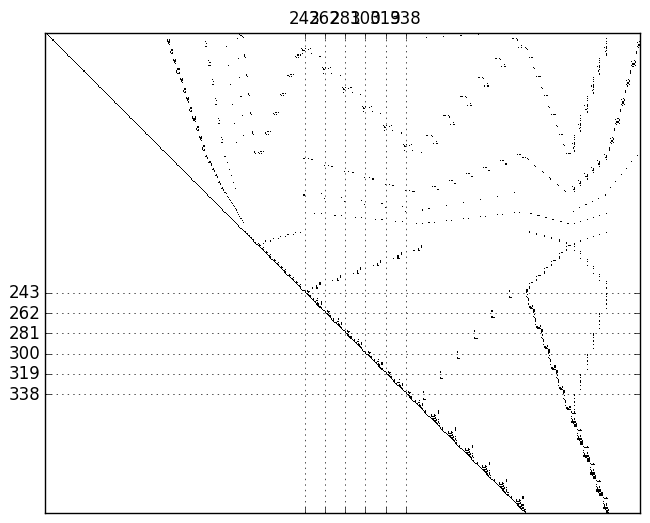

In [407]:
spy(U)
# axis("off")
yticks(find(diag(U1).==0))
xticks(find(diag(U1).==0))
grid(true)

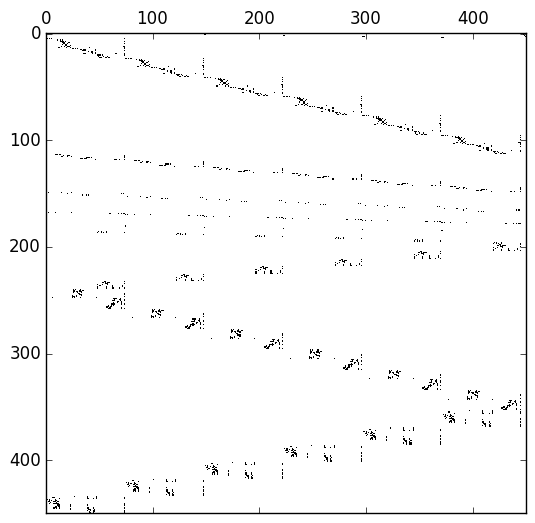

PyObject <matplotlib.image.AxesImage object at 0x7f3bbe9e7128>

In [332]:
spy(U1)

In [415]:
A = load("../data/A.jld","A")
q = permutecols(nr,nb,nt)
B = kernel_backsubs(sparse(A),q)
maxabs(A*B)

3.999220988041319e-15

In [8]:
"""
Given a permutation vector, return the corresponding permutation matrix such that
`A[p,:] = P*A`.
See [Wikipedia](https://en.wikipedia.org/wiki/Permutation_matrix#Definition).
"""
function pvec2mat(p)
    n = length(p)
    P = zeros(n,n)
    for i in 1:n
        P[i,:] = ej(n,p[i])
    end
    return sparse(P)
end

"""
Return the j-th standard basis vector with length n.
"""
function ej(n,j)
    v = zeros(n)
    v[j] = 1.0
    return v
end

ej (generic function with 1 method)

## Comparing functions

In [139]:
"""
Find an orthonormal basis for the nullspace of A.
This matrix may be used to rotate a temporal instanton
problem instance to eliminate all but nullity(A) elements.
"""
function kernel_basis(A::SparseMatrixCSC{Float64,Int64})
    m,n = size(A)
    # Assume A has full row rank
    dim_N = n - m
    F = qrfact(A')
    # B selects last dim_N cols of Q:
    B = [zeros(n-dim_N,dim_N); eye(dim_N)]
    N = sparse(SparseMatrix.SPQR.qmult(SparseMatrix.SPQR.QX, F, SparseMatrix.CHOLMOD.Dense(B)))
    return N
end


kernel_basis (generic function with 1 method)

In [152]:
sparse(round(Bold,8))

558x108 sparse matrix with 9936 Float64 entries:
	[1  ,   1]  =  -0.0657601
	[2  ,   1]  =  -0.0154564
	[3  ,   1]  =  -0.0257904
	[4  ,   1]  =  -0.0346138
	[5  ,   1]  =  -0.0387583
	[6  ,   1]  =  -0.00985561
	[7  ,   1]  =  0.00404939
	[8  ,   1]  =  -0.0426407
	[9  ,   1]  =  0.0117509
	[10 ,   1]  =  -0.164366
	⋮
	[543, 108]  =  -0.0165874
	[544, 108]  =  -0.0168277
	[545, 108]  =  -0.0149727
	[546, 108]  =  -0.0139952
	[547, 108]  =  -0.0167216
	[548, 108]  =  -0.0167663
	[549, 108]  =  -0.0134576
	[550, 108]  =  -0.0168163
	[551, 108]  =  -0.0124765
	[552, 108]  =  -0.0779428
	[558, 108]  =  0.00023866

In [180]:
@time Bold = kernel_basis(sparse(A))

  0.010556 seconds (153 allocations: 3.282 MB)


558x108 sparse matrix with 9936 Float64 entries:
	[1  ,   1]  =  -0.0657601
	[2  ,   1]  =  -0.0154563
	[3  ,   1]  =  -0.0257904
	[4  ,   1]  =  -0.0346138
	[5  ,   1]  =  -0.0387583
	[6  ,   1]  =  -0.00985561
	[7  ,   1]  =  0.00404939
	[8  ,   1]  =  -0.0426407
	[9  ,   1]  =  0.0117509
	[10 ,   1]  =  -0.164366
	⋮
	[543, 108]  =  -0.0165874
	[544, 108]  =  -0.0168277
	[545, 108]  =  -0.0149727
	[546, 108]  =  -0.0139952
	[547, 108]  =  -0.0167216
	[548, 108]  =  -0.0167663
	[549, 108]  =  -0.0134576
	[550, 108]  =  -0.0168163
	[551, 108]  =  -0.0124766
	[552, 108]  =  -0.0779428
	[558, 108]  =  0.000238659

In [176]:
nr,nb,nt = 18,73,6
q = permutecols(A,nr,nb,nt)
@time Bnew = sparse(kernel_backsubs(A,q))

  0.065826 seconds (684 allocations: 14.427 MB)


558x108 sparse matrix with 8208 Float64 entries:
	[1  ,   1]  =  1.0
	[19 ,   1]  =  2.39891e-17
	[20 ,   1]  =  0.00719408
	[21 ,   1]  =  -0.0476185
	[22 ,   1]  =  -0.0246909
	[23 ,   1]  =  -0.0219198
	[24 ,   1]  =  -0.0321221
	[25 ,   1]  =  -0.0685385
	[26 ,   1]  =  -0.0607461
	[27 ,   1]  =  -0.0508014
	⋮
	[543, 108]  =  0.0465003
	[544, 108]  =  0.0439342
	[545, 108]  =  0.0523793
	[546, 108]  =  0.0530137
	[547, 108]  =  0.046008
	[548, 108]  =  0.0449509
	[549, 108]  =  0.0533627
	[550, 108]  =  0.0614295
	[551, 108]  =  0.0501754
	[552, 108]  =  -1.0
	[558, 108]  =  8.71675e-5

In [313]:
nr,nb,nt = 18,73,6
q = permutecols(A,nr,nb,nt)
@time Bnew = kernel_backsubs(sparse(A),q)

  0.014943 seconds (1.09 k allocations: 10.980 MB)


558x108 Array{Float64,2}:
  1.0           0.0          0.0         …   0.0         0.0       
  0.0           1.0          0.0             0.0         0.0       
  0.0           0.0          1.0             0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  0.0           0.0          0.0         …   0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  0.0           0.0          0.0         …   0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  0.0           0.0          0.0             0.0         0.0       
  ⋮                                      ⋱                         
 -0.0          -0.0   

In [157]:
sparse(round(Bnew,8))

558x108 sparse matrix with 8100 Float64 entries:
	[1  ,   1]  =  1.0
	[20 ,   1]  =  0.00719408
	[21 ,   1]  =  -0.0476185
	[22 ,   1]  =  -0.0246909
	[23 ,   1]  =  -0.0219198
	[24 ,   1]  =  -0.0321221
	[25 ,   1]  =  -0.0685385
	[26 ,   1]  =  -0.0607461
	[27 ,   1]  =  -0.0508014
	[28 ,   1]  =  -0.0446132
	⋮
	[543, 108]  =  0.0465003
	[544, 108]  =  0.0439342
	[545, 108]  =  0.0523793
	[546, 108]  =  0.0530137
	[547, 108]  =  0.046008
	[548, 108]  =  0.0449509
	[549, 108]  =  0.0533627
	[550, 108]  =  0.0614294
	[551, 108]  =  0.0501754
	[552, 108]  =  -1.0
	[558, 108]  =  8.717e-5

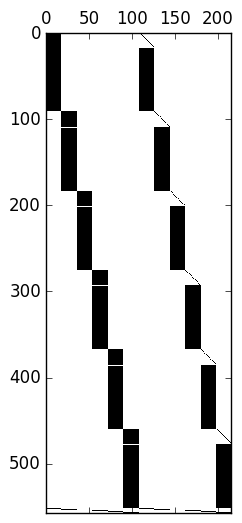

PyObject <matplotlib.image.AxesImage object at 0x7f3bbef41eb8>

In [158]:
spy([Bold Bnew])

## 2016-01-14, Block back-substitution

Strategy: begin by using the structure of the $A$ matrix to permute a set of linearly independent columns to the left. Then perform an LU decomposition on the square part. Use the row permutation vector to permute rows of the rectangular part, then compute $W$ and $B$.

In [18]:
"""
Return a column permutation q for a temporal instanton
A matrix such that the first m columns of A form a square,
nonsingular matrix. Useful for finding a null space basis
matrix via the back substitution method.
"""
function permutecols(nr,nb,nt)
    m = (nb+2)*nt
    n = (nr+nb+2)*nt
    q = Vector{Int64}()
    # take non-decision-var cols across all time steps
    for t in 1:nt
        append!(q,collect(nr+1:nr+nb+1)+(t-1)*(nr+nb+1))
    end
    # append aux. angle variable cols
    append!(q,collect(n-nt+1:n))
    q = [q;setdiff(1:n,q)]
    return q
end

"""
Return a basis for the null space of a dense rectangular m-by-n
matrix with rank m. Based on "back substitution algorithm"
as described in Berry 1985 (**DOI: 10.1007/BF01389453**). Input
`q` represents a column order such that the first m columns of
`A[:,q]` are linearly independent.

*Note: if `q` does not cause `A[:,1:m]` to have full rank, U1 will be 
singular. The method will fail with a `LAPACKException(k)`, where
`k` is the index of the first zero on the diagonal of U1.*
"""
function kernel_backsubs(
    A::SparseMatrixCSC{Float64,Int64},
    q=1:size(A,2)
    )
    m,n = size(A)
    
    F = lufact(A[:,q[1:m]]) # square part
    U1 = F[:U]
    p = F[:p]
    qlu = F[:q]
    U2 = A[p,q[m+1:end]] # rect. part (permute rows)
    
    W = UpperTriangular(U1)\U2
    
    qfinal = [q[1:m][qlu];q[m+1:end]]
    B = [-W;speye(n-m)][invperm(qfinal),:] # equiv. to 
    # pre-multiplying by pvec2mat(invperm(q))
end

kernel_backsubs (generic function with 2 methods)